In [1]:
import numpy as np
import torch
import torchvision
import tqdm
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
import torchvision.transforms as transforms
from torchvision import datasets
import os
import random

In [2]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2021-12-05 18:29:06--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/33l8lp62rmvtx40/dataset.zip [following]
--2021-12-05 18:29:06--  https://www.dropbox.com/s/dl/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4c8e2f7dcbf0e4a2da266ae75c.dl.dropboxusercontent.com/cd/0/get/BbRH7OyVlfVU39JbVpon6xZ_Xbu1fvfy1RQKNNyc4dkWfyF9UmQcb9x7r9ZisTX9_GMy7Z9csri6WGtbWbsqwRS9LsRulVg-GFowaIBUVwkJaqJrBo7S21gJ90nAkyg2iTuPLErUM738UFBbxKPSjhgA/file?dl=1# [following]
--2021-12-05 18:29:06--  https://uc4c8e2f7dcbf0e4a2da266ae75c.dl.dropboxusercontent.com/cd/0/get/BbRH7OyVlfVU39JbVpon6xZ_Xbu1fvfy1RQKNNyc4dkWfyF9UmQcb9x7r9ZisTX9_GMy7Z9csri6WGtbWbsqwRS9LsR

### Подготовка данных

In [3]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform):
        super().__init__()
        self.data_dir = data_dir
        self.data = datasets.ImageFolder(data_dir, transform) 
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def __len__(self):
        return len(self.data)

### Посмотрим на данные:

In [4]:
classes = list(range(0, 200))

In [22]:
train_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      ])
batch_size = 4

train_dataset = MyDataset("./dataset/dataset/train", transform=train_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

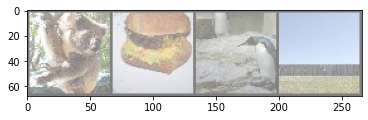

Классы:
  191   120    83   149


In [23]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('Классы:')
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

### Посчитаем средние значения и стандартные отклонения по каждому каналу для получения гиперпараметров `transforms.Normalize`:

In [24]:
acc_mean = 0
acc_std = 0
for image, _ in train_dataloader:
    mean = image.mean(dim = (0, 2, 3))
    std = image.std(dim = (0, 2, 3))
    acc_mean += mean
    acc_std += std
display(acc_mean / len(train_dataloader))
display(acc_std / len(train_dataloader))

tensor([0.4802, 0.4481, 0.3975])

tensor([0.2658, 0.2588, 0.2686])

### Чтобы каждый раз не пересчитывать, запишем значения в переменные:

In [7]:
mean = [0.4802, 0.4481, 0.3975]
std = [0.2756, 0.2678, 0.2804]

In [8]:
train_transform = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomHorizontalFlip(0.25),
        transforms.ColorJitter(brightness=.3, hue=.2),
        transforms.TrivialAugmentWide(),
        transforms.RandomSolarize(threshold=192.0)
    ], p=0.6),
                                      transforms.ToTensor(),
    transforms.Normalize(mean, std),
                                      ])

val_transform = transforms.Compose([
                                      transforms.ToTensor(),
    transforms.Normalize(mean, std),
                                      ])
batch_size = 224

train_dataset = MyDataset("./dataset/dataset/train", transform=train_transform)
val_dataset = MyDataset("./dataset/dataset/val", transform=val_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                         shuffle=False)

In [10]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

### Функции для обучения:

In [13]:
import tqdm

def train(model, train_dataloader, eval_dataloader, criterion, optimizer, device="cpu", n_epochs=27, schedulder=None):
    for epoch in range(n_epochs):
        print('-' * 80)
        print(epoch + 1, 'эпоха из', n_epochs)
        train_one_epoch(model, train_dataloader, criterion, optimizer, device)
        loss = evaluate(model, eval_dataloader, criterion, device)
        if schedulder is not None:
            schedulder.step(loss)
    
    
def train_one_epoch(model, train_dataloader, criterion, optimizer, device):
    progress_bar = tqdm.notebook.tqdm(train_dataloader)
    model = model.to(device).train()
    idx = 0
    for (images, labels) in progress_bar:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if idx % 10 == 0:
            progress_bar.set_description("Loss = {:.4f}".format(loss.item()))
        idx += 1
        
def evaluate(model, eval_dataloader, criterion, device="cuda:0"):
    cumulative_loss = 0
    acc = 0
    model = model.eval()
    with torch.no_grad():
        for idx, (images, labels) in enumerate(eval_dataloader): 
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            loss = criterion(preds, labels)
            cumulative_loss += loss.item()
            acc += (preds.argmax(1) == labels).float().mean()
    print("Loss = {:.4f}".format(cumulative_loss / idx), "val accuracy = {:.4f}".format(acc / idx))
    return cumulative_loss

### Архитектура нейронной сети:

In [14]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, (3, 3)),
            nn.MaxPool2d((2, 2)),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, (3, 3)),
            nn.MaxPool2d((2, 2)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, (3, 3)),
            nn.MaxPool2d((2, 2)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        ) 
        
        
        self.block4 = nn.Sequential(
             nn.Conv2d(64, 100, (3, 3)),
             nn.MaxPool2d((2, 2)),
             nn.ReLU(),
             nn.BatchNorm2d(100),
         )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(400, 1024),
            nn.BatchNorm1d(num_features=1024),
            nn.ReLU(),
            nn.Linear(1024, 200),
        )
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return self.classifier(x)
model = MyModel()

### Обучение:

In [15]:
SEED = 42
set_random_seed(SEED) 
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
schedulder = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)

criterion = nn.CrossEntropyLoss()

train(model, train_dataloader, val_dataloader, criterion, optimizer, device='cuda', schedulder = schedulder)

--------------------------------------------------------------------------------
1 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 3.8960 val accuracy = 0.1764
--------------------------------------------------------------------------------
2 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 3.5782 val accuracy = 0.2247
--------------------------------------------------------------------------------
3 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 3.4014 val accuracy = 0.2574
--------------------------------------------------------------------------------
4 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 3.2770 val accuracy = 0.2818
--------------------------------------------------------------------------------
5 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 3.2229 val accuracy = 0.2923
--------------------------------------------------------------------------------
6 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 3.1555 val accuracy = 0.3105
--------------------------------------------------------------------------------
7 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 3.0999 val accuracy = 0.3269
--------------------------------------------------------------------------------
8 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 3.0776 val accuracy = 0.3199
--------------------------------------------------------------------------------
9 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 3.1094 val accuracy = 0.3241
--------------------------------------------------------------------------------
10 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 3.0471 val accuracy = 0.3296
--------------------------------------------------------------------------------
11 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 3.0416 val accuracy = 0.3350
--------------------------------------------------------------------------------
12 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 3.0341 val accuracy = 0.3362
--------------------------------------------------------------------------------
13 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 3.0325 val accuracy = 0.3422
--------------------------------------------------------------------------------
14 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 3.0515 val accuracy = 0.3380
--------------------------------------------------------------------------------
15 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 3.0763 val accuracy = 0.3356
--------------------------------------------------------------------------------
16 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 2.9379 val accuracy = 0.3631
--------------------------------------------------------------------------------
17 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 2.9313 val accuracy = 0.3671
--------------------------------------------------------------------------------
18 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 2.9330 val accuracy = 0.3671
--------------------------------------------------------------------------------
19 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 2.9292 val accuracy = 0.3661
--------------------------------------------------------------------------------
20 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 2.9280 val accuracy = 0.3664
--------------------------------------------------------------------------------
21 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 2.9309 val accuracy = 0.3663
--------------------------------------------------------------------------------
22 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 2.9355 val accuracy = 0.3663
--------------------------------------------------------------------------------
23 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 2.9301 val accuracy = 0.3679
--------------------------------------------------------------------------------
24 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 2.9239 val accuracy = 0.3676
--------------------------------------------------------------------------------
25 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 2.9292 val accuracy = 0.3686
--------------------------------------------------------------------------------
26 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 2.9235 val accuracy = 0.3679
--------------------------------------------------------------------------------
27 эпоха из 27


  0%|          | 0/447 [00:00<?, ?it/s]

Loss = 2.9255 val accuracy = 0.3688


### Посмотрим на предсказания модели:

In [16]:
def predict(model, eval_dataloader, criterion, device="cuda"):
    cumulative_loss = 0
    acc = 0
    model = model.eval()
    losses = []
    predicted_classes = []
    true_classes = []
    with torch.no_grad():
        for idx, (images, labels) in enumerate(eval_dataloader): 
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            loss = criterion(preds, labels)
            cumulative_loss += loss.item()
            losses.append(loss.item())
            predicted_classes += list(preds.argmax(1).cpu().detach().numpy())
            true_classes += list(labels.cpu().detach().numpy()) 
            acc += (preds.argmax(1) == labels).float().mean()
    return list(losses), list(predicted_classes), list(true_classes)

In [18]:
def finisheval(model, eval_dataloader, criterion):
    all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion)
    return accuracy_score(predicted_labels, true_labels)

In [19]:
accuracy = finisheval(model, val_dataloader, criterion)
accuracy

0.3599

# Отчет по проделанным экспериментам:

### Сначала были испрованы обычные и неглубокие CNN, но качество было не очень:

In [ ]:
train_transform = transforms.Compose([
                                      transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                      ])
val_transform = transforms.Compose([
                                      transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                      ])
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(2704, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 200)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

`accuracy = 0.11`

### Сразу же я попробовал другую стратегию, а именно дообучение.


In [ ]:
from torchvision.models import resnet18
model = resnet18(pretrained=True)
model.fc = nn.Sequential(nn.Linear(512, 200))

`Loss = 3.8749 accuracy = 0.1383
Loss = 3.5126 accuracy = 0.2002`

In [ ]:
from torchvision.models import AlexNet
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.classifier[6] = nn.Linear(4096,200)

`[1,  2000] loss: 4.782`
`[1,  4000] loss: 4.259`
`[1,  6000] loss: 4.088`
`[1,  8000] loss: 3.979`
`[1, 10000] loss: 3.918`
`[1, 12000] loss: 3.867`
`[1, 14000] loss: 3.842`
`[1, 16000] loss: 3.807`
`[1, 18000] loss: 3.769`
`[1, 20000] loss: 3.742`
`[1, 22000] loss: 3.716`
`[1, 24000] loss: 3.771`

`acuracy = 0.18 %`

### Я запустил модель побольше:

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, (3, 3)),
            nn.MaxPool2d((2, 2)),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, (3, 3)),
            nn.MaxPool2d((2, 2)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, (3, 3)),
            nn.MaxPool2d((2, 2)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2304, 256),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(256, 200),
        )
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        return self.classifier(x)
model = MyModel()
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
criterion = nn.CrossEntropyLoss()

`accuracy = 0.2658`

### Для ее улучшения был добавлен еще один сверточный слой (больше обучаемых параметров!!!):

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, (3, 3)),
            nn.MaxPool2d((2, 2)),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, (3, 3)),
            nn.MaxPool2d((2, 2)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, (3, 3)),
            nn.MaxPool2d((2, 2)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        ) 
        
        self.block4 = nn.Sequential(
            nn.Conv2d(64, 128, (3, 3)),
            nn.MaxPool2d((2, 2)),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(256, 200),
        )
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return self.classifier(x)


`Loss = 3.5855 val accuracy = 0.2016`

`Loss = 3.3568 val accuracy = 0.2460`


### Далее пошли эксперименты с аугментациями и увеличение количества нейронов линейного слоя:

In [ ]:
transforms.RandomApply([
        transforms.RandomHorizontalFlip(0.25),
        transforms.ColorJitter(brightness=.3, hue=.2),
        transforms.RandomVerticalFlip(0.25),
        transforms.TrivialAugmentWide(),
        transforms.RandomSolarize(threshold=192.0)
    ], p=0.6),
    transforms.RandomVerticalFlip(0.2),
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(512, 200),
        )
Loss = 2.8494 val accuracy = 0.3564

### Оказалось, что аугментация - штука коварная и не надо ею злоупотреблять и остановился на таком варианте:

In [ ]:
transforms.RandomApply([
        transforms.RandomHorizontalFlip(0.25),
        transforms.ColorJitter(brightness=.3, hue=.2),
        transforms.TrivialAugmentWide(),
        transforms.RandomSolarize(threshold=192.0)
    ], p=0.6),

### После очень большого количества проб и ошибок принято решение убрать `Dropout`. Также добавление `Batchnorm` в линейные слои не давало большого прироста. Еще добавлены нейроны в линейный слой.

### Так же отличной фишкой оказался поиск средних значений и стандартных отклонений по каждому каналу для получения гиперпараметров transforms.Normalize:

### `schedulder = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)` давал неплохой такой буст с 3 эпохи!

### Ну и конечно `set_random_seed()`.

### Все варианты с `lr = 1e-4` не увенчались успехом, слишком маленькое значение. Модели обучались очень долго и качество не улучшалось по эпохам. 

### Поиграв с `batchsize` вариант `128` был неплохим. Но дальше я решил менять их, веря в лучший результат 

In [ ]:
...
self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(400, 1000),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(1000, 200),
        )
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return self.classifier(x)

`SEED = 42`

`optimizer = torch.optim.Adam(model.parameters(), 1e-3)`

`schedulder = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0)`

После 25 эпох:


`Accuracy = 0.3595` 

# В конце концов я пришел к 2 "крайним" версиям:

`batch_size = 242`

In [ ]:
...
self.block4 = nn.Sequential(
             nn.Conv2d(64, 120, (3, 3)),
             nn.MaxPool2d((2, 2)),
             nn.ReLU(),
             nn.BatchNorm2d(120),
         )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(480, 800),
            nn.ReLU(),
            nn.Linear(800, 200),
        )

`SEED = 42`

`optimizer = torch.optim.Adam(model.parameters(), 1e-3)`

`schedulder = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=0)`

После 27 эпох:

`accuracy = 0.3470`

# -----------------------------------------------------------------------------

`batch_size = 224`

In [ ]:
...
self.block4 = nn.Sequential(
             nn.Conv2d(64, 100, (3, 3)),
             nn.MaxPool2d((2, 2)),
             nn.ReLU(),
             nn.BatchNorm2d(100),
         )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(400, 1024),
            nn.BatchNorm1d(num_features=1024),
            nn.ReLU(),
            nn.Linear(1024, 200),
        )

`SEED = 42`

`optimizer = torch.optim.Adam(model.parameters(), 1e-3)`

`schedulder = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1)`

После 25 эпох:

`accuracy = 0.3599`

### Этот вариант оказался финальным !!!